In [50]:
%matplotlib inline

import pandas as pd
from datetime import timedelta
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.api import *

## 1. Exploratory Analysis and Data Preparation

In [33]:
df = pd.read_csv("Upwork 20160117.csv")
df.columns = [x.lower().replace(" ", "_") for x in df.columns]
df = df.set_index("date")
df.index = pd.to_datetime(df.index, format="%m/%d/%Y")

#### 1. Buy Swing = High0 - Open0
#### 2. Sell Swing = Open0 - Low0

In [34]:
day_after_max_buy_swing = df.loc[df["buy_swing"] == df["buy_swing"].max()].index + timedelta(days=1)
df.loc[day_after_max_buy_swing]

,open,high,low,close,direction,buy_swing,sell_swing
date,,,,,,,
2015-08-26,5205,5230,5007,5192,DOWN,25,198


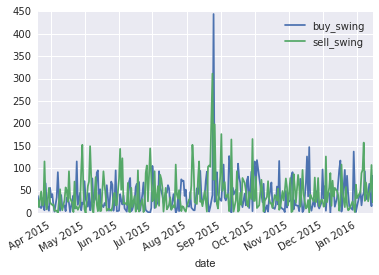

In [35]:
df[["buy_swing", "sell_swing"]].plot()

From the graph below I can conclude that the stock price does not follow an exponential decline, just a trending decline, I won't use log values, but maybe first differences to take care of the downward trend

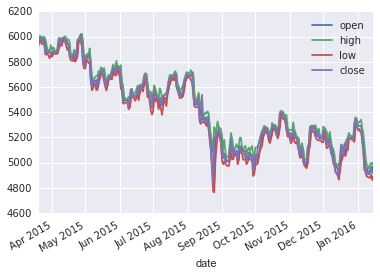

In [36]:
df[["open", "high", "low", "close"]].plot()

In [37]:
cols_to_difference = ["open", "high", "low", "close"]
differenced_cols = []
for col in cols_to_difference:
    name = col + "_1_diff"
    df[name] = df[col].diff()
    differenced_cols.append(name)

Now it seems much better (the graph bellow). We have a stationary data of daily prices, the downward trend is differenced out and the variability of the underlying stock remaims. Now a model can be fitted.

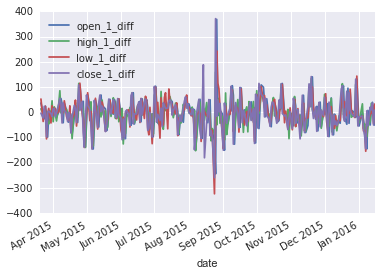

In [38]:
df[differenced_cols].plot()

One way to examine the relationship in the stock is to plot the variable againt its lag value. Lets create a lagged value column from the differenced "open_1_diff" and plot these two columns.

In [39]:
df["open_diff_lagged"] = df["open_1_diff"].shift()

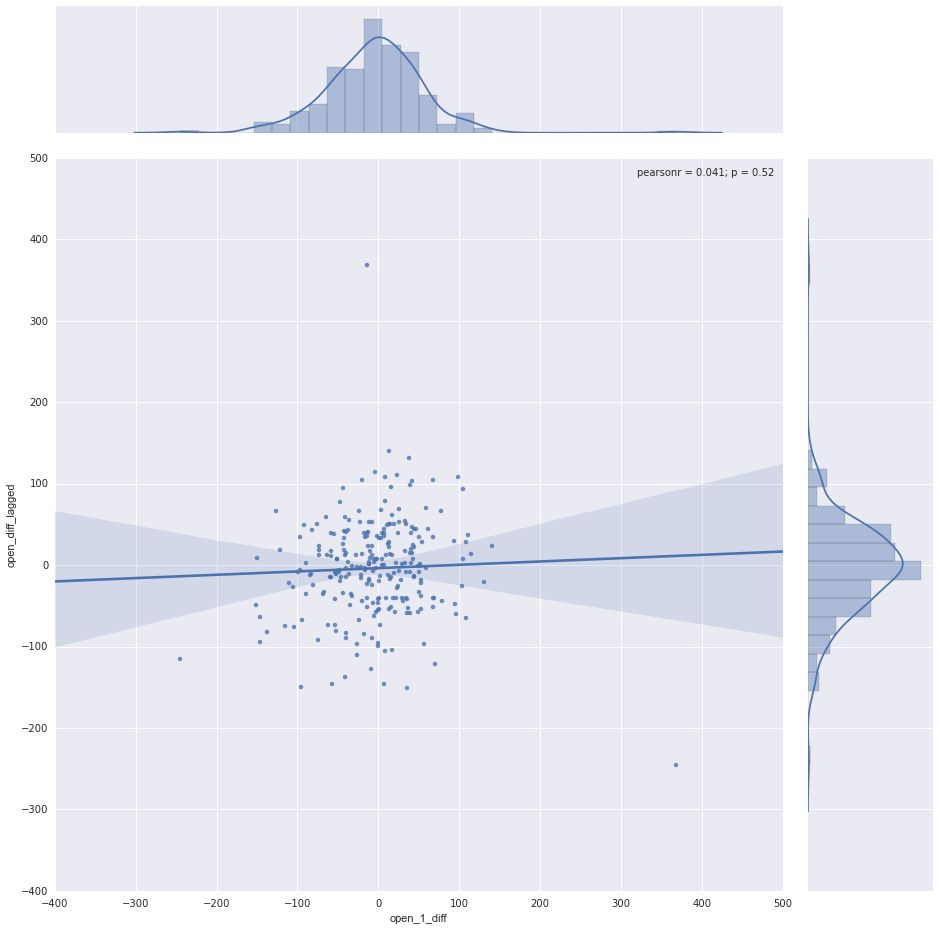

In [40]:
import seaborn as sb

sb.jointplot("open_1_diff", "open_diff_lagged", df, kind='reg', size=13)

There's no obvious relationship, it seems that the observations are evenly distributed, but lets fit a model and see its accuracy.

### Let's build the dataframe so that it fits the needed structure

- Rows Should contain: todays open, previous open lags, yesterdays high/low/close and buy and sell swing. Further lags won't be added, but selected based on the model.

- For modelling purposes todays high/low/close/buy&sell swing aren't needed (unknowns), so I'll shift these columns to have todays open and previous days observations for the other columns in the same row.

In [41]:
df

,open,high,low,close,direction,buy_swing,sell_swing,open_1_diff,high_1_diff,low_1_diff,close_1_diff,open_diff_lagged
date,,,,,,,,,,,,
2015-03-20,5953,5991,5924,5989,UP,38,29,NaN,NaN,NaN,NaN,NaN
2015-03-21,5989,6004,5976,5985,DOWN,15,13,36,13,52,-4,NaN
2015-03-23,5987,5998,5939,5962,DOWN,11,48,-2,-6,-37,-23,36
2015-03-24,5961,5993,5944,5985,UP,33,17,-26,-5,5,23,-2
2015-03-25,5985,5998,5967,5976,DOWN,14,18,24,5,23,-9,-26
2015-03-26,5977,5983,5861,5878,DOWN,6,115,-8,-15,-106,-98,24
2015-03-27,5878,5944,5855,5878,DOWN,66,24,-99,-39,-6,0,-8
2015-03-28,5878,5897,5870,5882,UP,19,8,0,-47,15,4,-99
2015-03-30,5882,5887,5827,5876,DOWN,5,56,4,-10,-43,-6,0


In [42]:
cols_to_shift = ["high_1_diff", "low_1_diff", "close_1_diff", "buy_swing", "sell_swing"]

for col in cols_to_shift:
    col_name = col + "_shifted"
    df[col_name] = df[col].shift(1)

In [43]:
df.head()

,open,high,low,close,direction,buy_swing,sell_swing,open_1_diff,high_1_diff,low_1_diff,close_1_diff,open_diff_lagged,high_1_diff_shifted,low_1_diff_shifted,close_1_diff_shifted,buy_swing_shifted,sell_swing_shifted
date,,,,,,,,,,,,,,,,,
2015-03-20,5953,5991,5924,5989,UP,38,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-21,5989,6004,5976,5985,DOWN,15,13,36,13,52,-4,NaN,NaN,NaN,NaN,38,29
2015-03-23,5987,5998,5939,5962,DOWN,11,48,-2,-6,-37,-23,36,13,52,-4,15,13
2015-03-24,5961,5993,5944,5985,UP,33,17,-26,-5,5,23,-2,-6,-37,-23,11,48
2015-03-25,5985,5998,5967,5976,DOWN,14,18,24,5,23,-9,-26,-5,5,23,33,17


## 2. Build Model

- I will build the model leaving out the last four observations so that after making predictions I can validate by comparing my forecast to the last four observations

In [56]:
cols_for_model = ["open_1_diff", "high_1_diff_shifted", "low_1_diff_shifted",
                 "close_1_diff_shifted", "buy_swing_shifted", "sell_swing_shifted"]
df_model = df[cols_for_model].dropna()

In [71]:
df_to_forecast = df_model[:-4]

In [72]:
model = VAR(df_to_forecast)
model.select_order()

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         42.07        42.16    1.866e+18        42.11
1         24.85       25.47*    6.204e+10        25.10
2         24.36        25.50    3.785e+10       24.82*
3         24.21        25.89    3.284e+10        24.89
4         24.23        26.43    3.334e+10        25.12
5         23.98        26.72    2.613e+10        25.08
6         24.03        27.30    2.765e+10        25.34
7         24.02        27.82    2.762e+10        25.55
8        23.76*        28.09   2.159e+10*        25.50
9         23.79        28.64    2.256e+10        25.75
10        23.86        29.25    2.481e+10        26.03
11        23.89        29.80    2.606e+10        26.27
12        23.90        30.35    2.727e+10        26.50
13        23.87        30.85    2.741e+10        26.68
14        23.95        31.46    3.098e+10        26.98
15        

{'aic': 8, 'bic': 1, 'fpe': 8, 'hqic': 2}

In [73]:
results = model.fit(1)
lag_order = results.k_ar

In [81]:
low_forecasts = []
for prediction in results.forecast(df_to_forecast.values[-lag_order :], 4):
    low_forecasts.append(prediction[2])

## 3. Validate Model

Original Values

In [79]:
df_model[-4:]["low_1_diff_shifted"]

date
2016-01-12    -9
2016-01-13    -4
2016-01-14    29
2016-01-15   -45
Name: low_1_diff_shifted, dtype: float64

In [82]:
low_forecasts

[-33.222946931482042,
 1.6355129982997099,
 2.0504159631067331,
 -1.6063664103166708]

Ok so basically what I did here is predict the last four values and then compared to the observed values. The prediction is off and it was obvious from the graphs that after differencing the stock follows a random walk. At least, genreally, the direction is predicted.